# Deviation of Results from the Expectations

This document shows how much the results of the preliminary minitest (PM) deviate from the expectations marked by the IRT analysis, and especially how much the results of the final minitest (PM) deviate from the expectations marked by the IRT 

## Analysis question by question

 question  expected_total  std_dev  z_score_min  z_score_max  obs_total_pm  obs_total_fm  z_score_pm  z_score_fm  delta_z_score  IRT-PM_deviation  IRT-FM_deviation  PM-FM_deviation  p_value_pm  p_value_fm
        1          16.741 3.117969    -5.369201     7.459664            28            37    3.611005    6.497499       2.886495          0.484071          0.871018         0.386947      0.0001         0.0
        2          17.332 3.130433    -5.536615     7.241172            25            38    2.449502    6.602282       4.152781          0.338274          0.911770         0.573496      0.0128         0.0
        3          21.331 3.143980    -6.784712     5.938015            20             6   -0.423349   -4.876303      -4.452954          0.062397          0.718719         0.656322      0.3992         0.0
        4          16.009 3.098578    -5.166564     7.742585            17            39    0.319824    7.419856       7.100032          0.041307          0.958318         0.917011

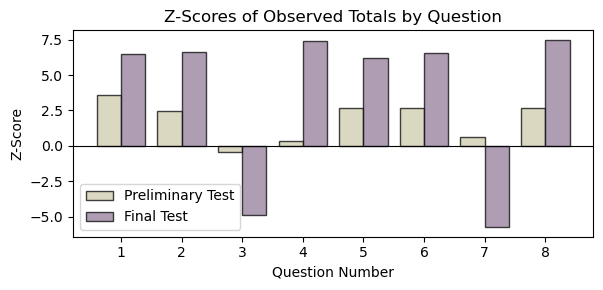

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Initialize lists to store results
results_per_question = []

def analyze_question(questionNum):
    # Get question label
    question = f'Q{questionNum}'

    # Extract probabilities for the question
    probs = data[f'{question}_prob'].values

    # Extract observed responses for preliminary and final minitests
    obs_pm = data[f'{question}_pm'].values.astype(int)
    obs_fm = data[question].values.astype(int)
    n_students = len(probs)

    # Expected total correct responses
    expected_total = probs.sum()

    # Variance and standard deviation
    variances = probs * (1 - probs)
    total_variance = variances.sum()
    std_dev = np.sqrt(total_variance)

    # Z-Score minimum and maximum
    # When all answers are wrong, z_score_min is computed as:
    z_score_min = (0 - expected_total) / std_dev
    # When all answers are correct, z_score_max is computed as:
    z_score_max = (n_students - expected_total) / std_dev

    # Observed total correct responses
    obs_total_pm = obs_pm.sum()
    obs_total_fm = obs_fm.sum()

    # Simulation for p-value
    n_simulations = 10000
    sim_totals = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_totals.append(sim_responses.sum())
    sim_totals = np.array(sim_totals)

    # P-value for preliminary minitest
    p_value_pm = np.mean(sim_totals >= obs_total_pm) if obs_total_pm >= expected_total else np.mean(sim_totals <= obs_total_pm)

    # P-value for final minitest
    p_value_fm = np.mean(sim_totals >= obs_total_fm) if obs_total_fm >= expected_total else np.mean(sim_totals <= obs_total_fm)

    # Calculate z-scores
    z_score_pm = (obs_total_pm - expected_total) / std_dev
    z_score_fm = (obs_total_fm - expected_total) / std_dev

    # Calculate change in z-scores (not absolute value)
    delta_z_score = z_score_fm - z_score_pm

    # Calculate deviations
    IRT_PM_deviation = z_score_pm / z_score_min if z_score_pm < 0 else z_score_pm / z_score_max
    IRT_FM_deviation = z_score_fm / z_score_min if z_score_fm < 0 else z_score_fm / z_score_max
    PM_FM_deviation = delta_z_score / z_score_min if delta_z_score < 0 else delta_z_score / z_score_max

    # Store data for visualization
    results = {
        'question': questionNum,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'z_score_min': z_score_min,
        'z_score_max': z_score_max,
        'obs_total_pm': obs_total_pm,
        'obs_total_fm': obs_total_fm,
        'z_score_pm': z_score_pm,
        'z_score_fm': z_score_fm,
        'delta_z_score': delta_z_score,
        'IRT-PM_deviation': IRT_PM_deviation,
        'IRT-FM_deviation': IRT_FM_deviation,
        'PM-FM_deviation': PM_FM_deviation,
        'p_value_pm': p_value_pm,  # Include p_value_pm in the dictionary
        'p_value_fm': p_value_fm   # Include p_value_fm in the dictionary
    }

    return results

# Analyze each question and collect results
for q_num in range(1, 9):
    result = analyze_question(q_num)
    results_per_question.append(result)

# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame(results_per_question)

# Display the results in the desired format
print(results_df.to_string(index=False))

# Extract z-scores and question numbers for plotting
questions = results_df['question']
z_scores_pm = results_df['z_score_pm']
z_scores_fm = results_df['z_score_fm']

# Plotting z-scores
bar_width = 0.4
index = np.arange(len(questions))

plt.figure(figsize=(6, 3))
plt.bar(index, z_scores_pm, bar_width, label='Preliminary Test', alpha=0.8, color='#D1CFB1', edgecolor='#111111')
plt.bar(index + bar_width, z_scores_fm, bar_width, label='Final Test', alpha=0.8, color='#9B85A2', edgecolor='#111111')


plt.xlabel('Question Number')
plt.ylabel('Z-Score')
plt.title('Z-Scores of Observed Totals by Question')
plt.xticks(index + bar_width / 2, questions)
plt.axhline(0, color='black', linewidth=0.8)

# Adding p-values as text on top of each bar
for i, (z_pm, z_fm, q_num) in enumerate(zip(z_scores_pm, z_scores_fm, questions)):
    # Check if 'p_value_pm' and 'p_value_fm' columns exist before accessing them
    if 'p_value_pm' in results_df.columns and 'p_value_fm' in results_df.columns:
        p_value_pm = results_df.iloc[i]['p_value_pm']
        p_value_fm = results_df.iloc[i]['p_value_fm']
        #plt.text(i, z_pm + 0.1, f'p={p_value_pm:.4f}', ha='center', va='bottom', fontsize=8, color='black')
        #plt.text(i + bar_width, z_fm + 0.1, f'p={p_value_fm:.4f}', ha='center', va='bottom', fontsize=8, color='black')

plt.legend()
plt.tight_layout()
plt.show()


##### In the version below, the plot changes from zScores to deviation rate.

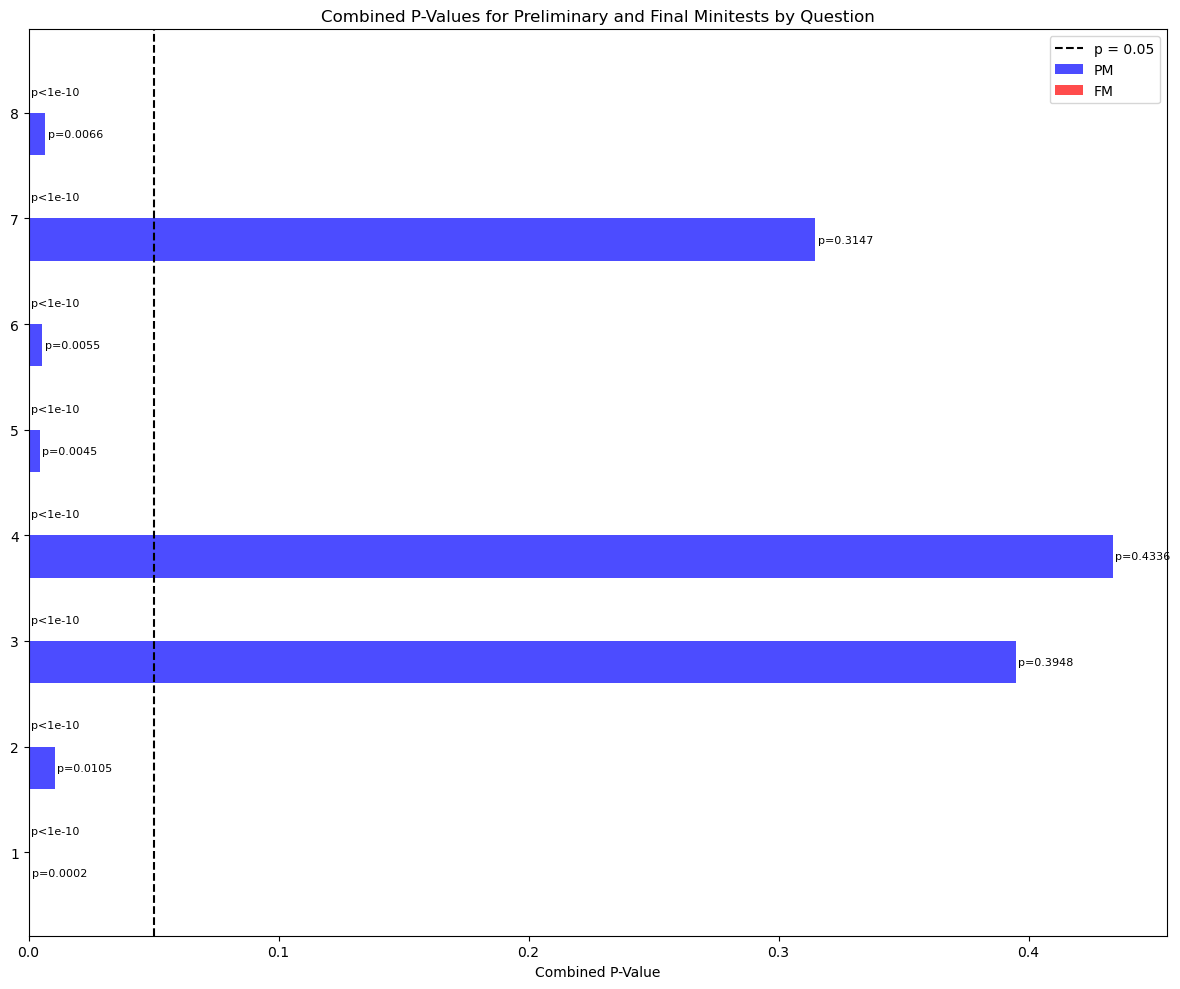

In [25]:
import matplotlib.pyplot as plt

# Ensure that p-values less than 1e-10 are set to 1e-10 for visualization
def adjust_p_value(p_value):
    return p_value if p_value > 1e-10 else 1e-10

# Adjust p-values for visualization
results_df['p_value_pm_adj'] = results_df['p_value_pm'].apply(adjust_p_value)
results_df['p_value_fm_adj'] = results_df['p_value_fm'].apply(adjust_p_value)

# Plot p-values for each question
plt.figure(figsize=(12, 10))
bar_width = 0.4
index = np.arange(len(results_df))

# Create vertical bar plots
plt.barh(index, results_df['p_value_pm_adj'], bar_width, label='PM', color='blue', alpha=0.7)
plt.barh(index + bar_width, results_df['p_value_fm_adj'], bar_width, label='FM', color='red', alpha=0.7)

# Add question labels to y-axis
plt.yticks(index + bar_width / 2, results_df['question'])

# Add a vertical line at p=0.05 and label it
plt.axvline(x=0.05, color='black', linestyle='--', linewidth=1.5, label='p = 0.05')

# Annotate each bar with the actual p-value
for i in range(len(results_df)):
    # PM P-values
    pm_p_val = results_df['p_value_pm'][i]
    fm_p_val = results_df['p_value_fm'][i]
    
    plt.text(results_df['p_value_pm_adj'][i] + 0.001, i, f'p={pm_p_val:.4f}' if pm_p_val >= 1e-10 else 'p<1e-10',
             ha='left', va='center', fontsize=8, color='black')
    
    # FM P-values
    plt.text(results_df['p_value_fm_adj'][i] + 0.001, i + bar_width, f'p={fm_p_val:.4f}' if fm_p_val >= 1e-10 else 'p<1e-10',
             ha='left', va='center', fontsize=8, color='black')

# Set axis labels and title
plt.xlabel('Combined P-Value')
plt.title('Combined P-Values for Preliminary and Final Minitests by Question')
plt.legend()
plt.tight_layout()
plt.show()


### To be considered

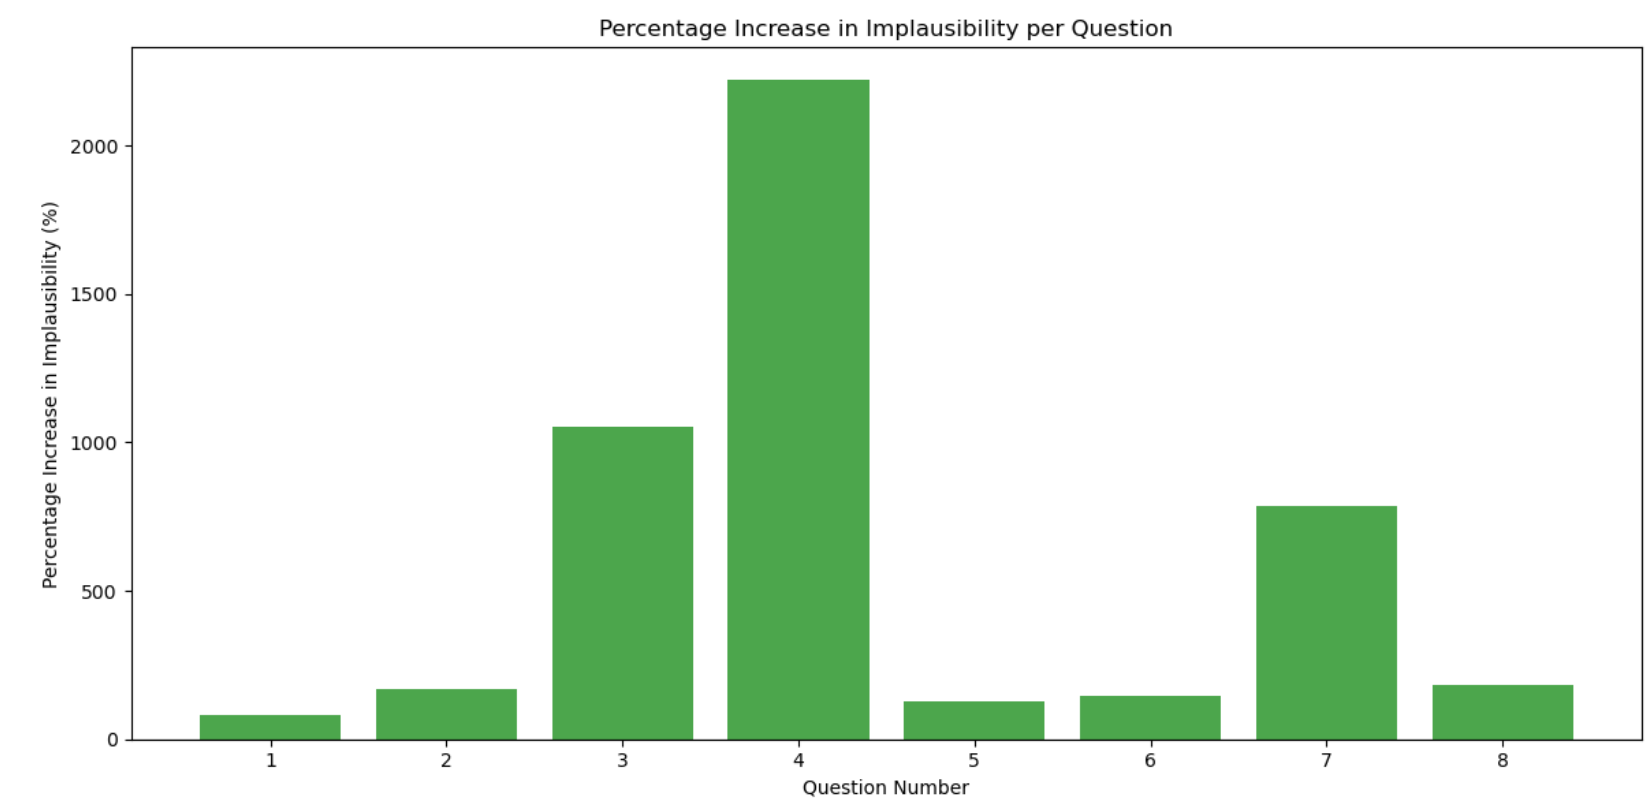

This graph was also produced by a previous version. It may be interesting, since it shows a difference between questions.

# Individual Performance Plausibility in both Preliminary and Final Minitest
Data Preparation: Reads data from CSV files and merges them into a single DataFrame.
Monte Carlo Simulation: Performs 10,000 simulations to compute expected values and confidence intervals.
Result Display: Outputs the results as a formatted table using print.
Visualization: Plots histograms to show the distribution of p-values for the Preliminary and Final Minitests.
By running this code in your environment, you'll be able to see the complete table and the visualizations as needed.

SUBJECT  Observed_Total_PM  Expected  95% CI Lower  95% CI Upper  Plausible_PM  P_Value_PM  Observed_Total_FM  Plausible_FM  P_Value_FM
     S1              0.624  0.478168         0.110      0.803000             1      0.1877              0.808             0      0.0245
     S2              0.680  0.435234         0.096      0.796000             1      0.1108              0.808             0      0.0166
     S3              0.711  0.440290         0.096      0.794000             1      0.0690              0.808             0      0.0163
     S4              0.715  0.435870         0.096      0.790000             1      0.0595              0.808             0      0.0139
     S7              0.471  0.436894         0.096      0.794000             1      0.4507              0.808             0      0.0157
     S8              0.330  0.418064         0.096      0.790000             1      0.6375              0.808             0      0.0122
     S9              0.903  0.479249         0.1

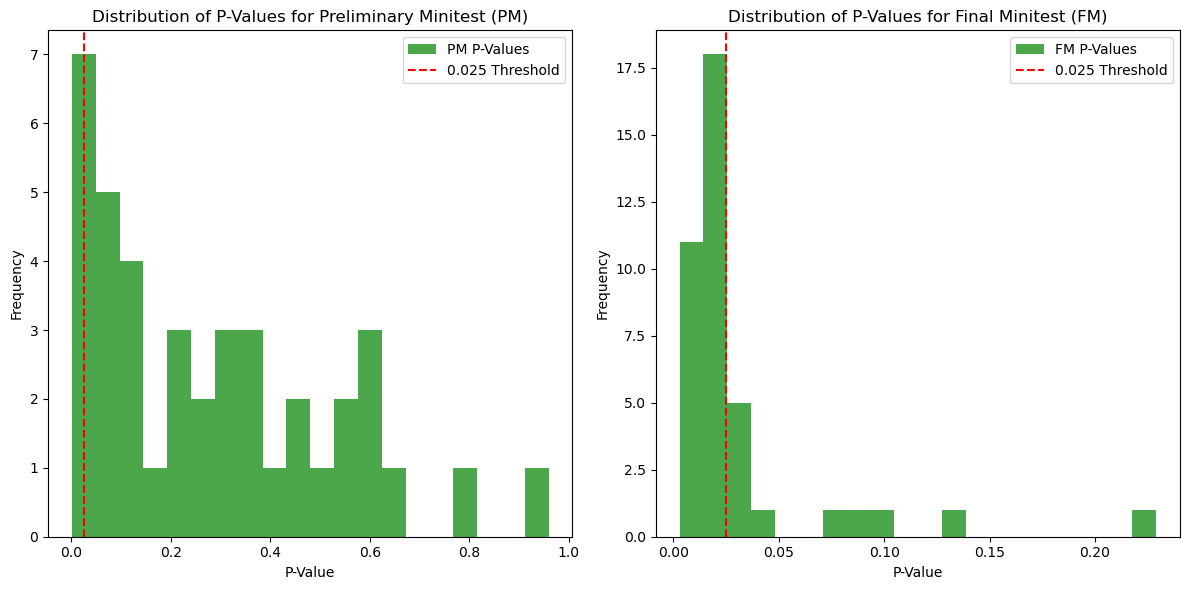

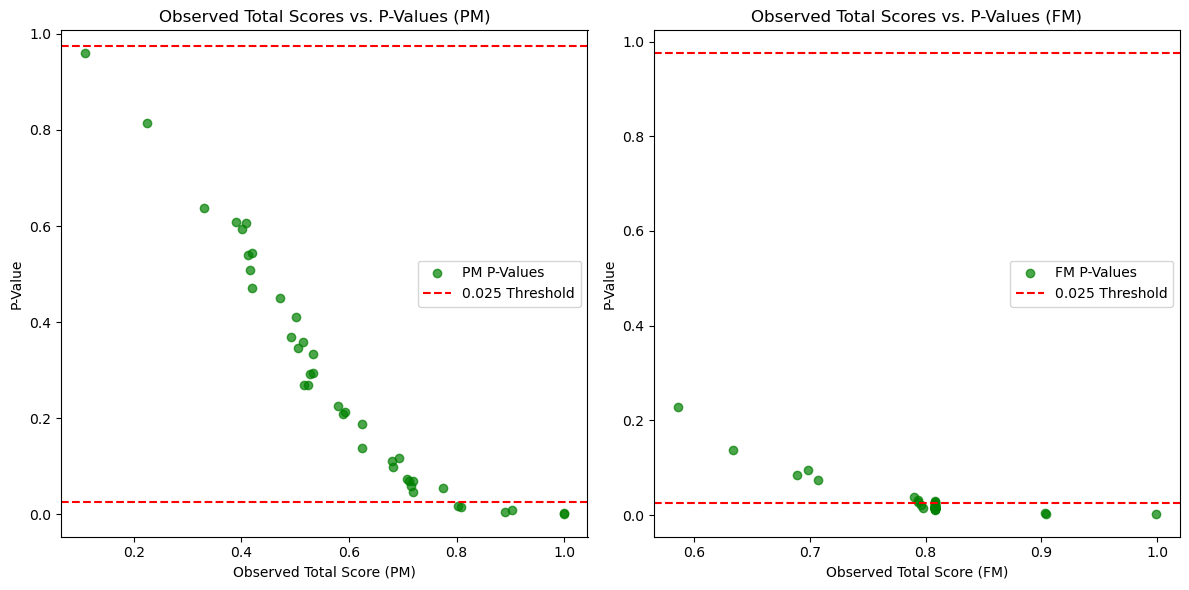

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Step 2: Monte Carlo Simulation for Each Student

n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Simulate scores once for both PM and FM
    sim_totals = []
    for _ in range(n_simulations):
        # Simulate responses using the probabilities
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals.append(sim_total)

    # Convert simulation results to a numpy array
    sim_totals = np.array(sim_totals)

    # Calculate the common expected values and confidence intervals
    expected_value = np.mean(sim_totals)
    lower_bound = np.percentile(sim_totals, 2.5)
    upper_bound = np.percentile(sim_totals, 97.5)

    # Calculate p-values for PM and FM using the same simulation
    p_value_pm = np.mean(sim_totals >= observed_total_pm)
    p_value_fm = np.mean(sim_totals >= observed_total_fm)

    # Determine if the observed results are plausible (95% confidence level)
    plausible_pm = 1 if p_value_pm >= 0.025 and p_value_pm <= 0.975 else 0
    plausible_fm = 1 if p_value_fm >= 0.025 and p_value_fm <= 0.975 else 0

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'Observed_Total_PM': observed_total_pm,
        'Expected': expected_value,
        '95% CI Lower': lower_bound,
        '95% CI Upper': upper_bound,
        'Plausible_PM': plausible_pm,
        'P_Value_PM': p_value_pm,
        'Observed_Total_FM': observed_total_fm,
        'Plausible_FM': plausible_fm,
        'P_Value_FM': p_value_fm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))

# Visualization of P-Values
plt.figure(figsize=(12, 6))

# Plot for Preliminary Minitest (PM)
plt.subplot(1, 2, 1)
plt.hist(results_df['P_Value_PM'], bins=20, color='green', alpha=0.7, label='PM P-Values')
plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Preliminary Minitest (PM)')
plt.legend()

# Plot for Final Minitest (FM)
plt.subplot(1, 2, 2)
plt.hist(results_df['P_Value_FM'], bins=20, color='green', alpha=0.7, label='FM P-Values')
plt.axvline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.xlabel('P-Value')
plt.ylabel('Frequency')
plt.title('Distribution of P-Values for Final Minitest (FM)')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot for Preliminary Minitest (PM)
plt.subplot(1, 2, 1)
plt.scatter(results_df['Observed_Total_PM'], results_df['P_Value_PM'], color='green', alpha=0.7, label='PM P-Values')
plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.axhline(0.975, color='red', linestyle='--')
plt.xlabel('Observed Total Score (PM)')
plt.ylabel('P-Value')
plt.title('Observed Total Scores vs. P-Values (PM)')
plt.legend()

# Plot for Final Minitest (FM)
plt.subplot(1, 2, 2)
plt.scatter(results_df['Observed_Total_FM'], results_df['P_Value_FM'], color='green', alpha=0.7, label='FM P-Values')
plt.axhline(0.025, color='red', linestyle='--', label='0.025 Threshold')
plt.axhline(0.975, color='red', linestyle='--')
plt.xlabel('Observed Total Score (FM)')
plt.ylabel('P-Value')
plt.title('Observed Total Scores vs. P-Values (FM)')
plt.legend()

plt.tight_layout()
plt.show()


## Improvement of previous:

## HERE:

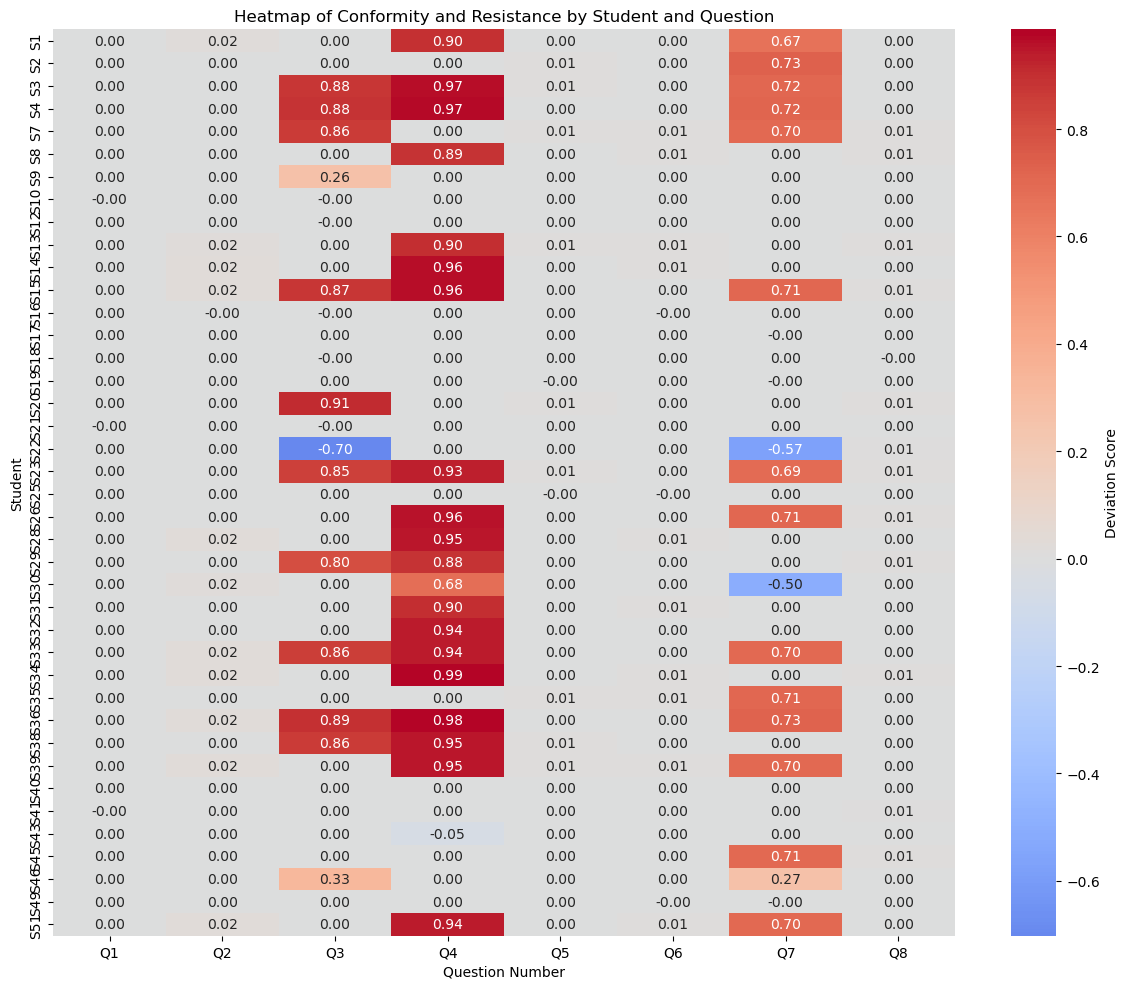

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Inputs
# Correct student deviation rates based on the given list of subjects
student_deviation = pd.DataFrame({
    'SUBJECT': [
        'S1', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S10', 'S12', 'S13',
        'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23',
        'S25', 'S26', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35',
        'S36', 'S38', 'S39', 'S40', 'S41', 'S43', 'S45', 'S46', 'S49', 'S51'
    ],
    'Deviation': [
        0.039473, 0.043331, 0.042376, 0.042464, 0.041615, 0.039102, 0.012764, 0, 0, 0.039571, 
        0.042195, 0.04218, 0, 0, 0, 0, 0.043877, 0, 0.033871, 0.041005, 
        0, 0.042076, 0.041687, 0.038761, 0.029863, 0.039682, 0.041222, 0.041411, 0.043245, 
        0.042092, 0.043106, 0.041661, 0.041746, 0, 0.017703, 0.002305, 0.04184, 0.015716, 0, 0.04141
    ]
})

# Question Deviation Rates
question_deviation = np.array([
    0.0002, 0.0107, 0.3924, 0.4314, 0.0048, 0.0056, 0.3195, 0.0054
])

# Conformity Matrix
conformity_matrix = np.array([
    [0, 1, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 1, 1, 1, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 0, 1, 1, 1, 1],
    [0, 0, 0, 1, 0, 1, 0, 1],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [-1, 0, -1, 1, 1, 1, 1, 0],
    [0, 0, -1, 0, 0, 0, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 1],
    [0, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 1, 0, 0, 1, 1],
    [0, -1, -1, 0, 0, -1, 1, 1],
    [0, 0, 1, 0, 0, 1, -1, 0],
    [0, 0, -1, 0, 0, 0, 1, -1],
    [0, 1, 1, 1, -1, 0, -1, 1],
    [0, 0, 1, 0, 1, 0, 0, 1],
    [-1, 0, -1, 0, 1, 0, 1, 0],
    [1, 0, -1, 0, 0, 0, -1, 1],
    [0, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, -1, -1, 0, 1],
    [0, 0, 0, 1, 0, 0, 1, 1],
    [0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0, 0, -1, 0],
    [1, 0, 0, 1, 0, 1, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 1, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 1, 0, 0, 0, 1, 0],
    [1, 1, 0, 0, 0, -1, -1, 0],
    [0, 1, 0, 1, 0, 1, 1, 0]
])

# Ensure the conformity matrix has the same number of rows as students
assert conformity_matrix.shape[0] == len(student_deviation), "Conformity matrix rows do not match number of students."

# Normalize deviation rates
student_deviation_norm = student_deviation['Deviation'] / student_deviation['Deviation'].max()
question_deviation_norm = question_deviation / question_deviation.max()

# Create heatmap data array
heatmap_data = np.zeros(conformity_matrix.shape)

# Populate heatmap data based on conformity matrix and deviation factors
for i in range(conformity_matrix.shape[0]):
    for j in range(conformity_matrix.shape[1]):
        conformity_value = conformity_matrix[i, j]
        if conformity_value != 0:
            # Multiply normalized deviation rates and conformity value
            heatmap_data[i, j] = conformity_value * student_deviation_norm[i] * question_deviation_norm[j]

# Create the heatmap plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    heatmap_data, 
    cmap="coolwarm", 
    center=0, 
    annot=True, 
    fmt=".2f", 
    cbar_kws={"label": "Deviation Score"}
)

# Set axis labels and title
plt.xticks(np.arange(len(question_deviation_norm)) + 0.5, [f'Q{i+1}' for i in range(len(question_deviation_norm))])
plt.yticks(np.arange(len(student_deviation)) + 0.5, student_deviation['SUBJECT'])
plt.xlabel("Question Number")
plt.ylabel("Student")
plt.title("Heatmap of Conformity and Resistance by Student and Question")

# Show the plot
plt.tight_layout()
plt.show()


# Below the version I thought was final:

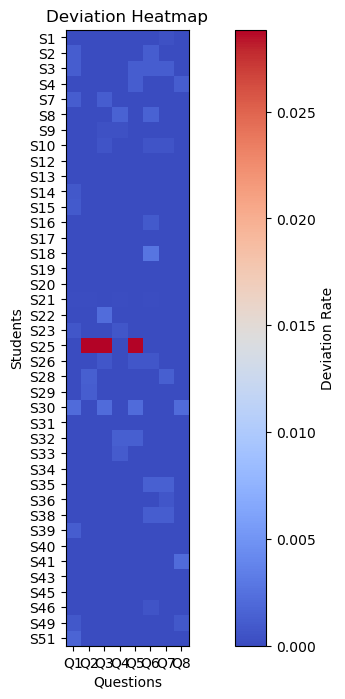

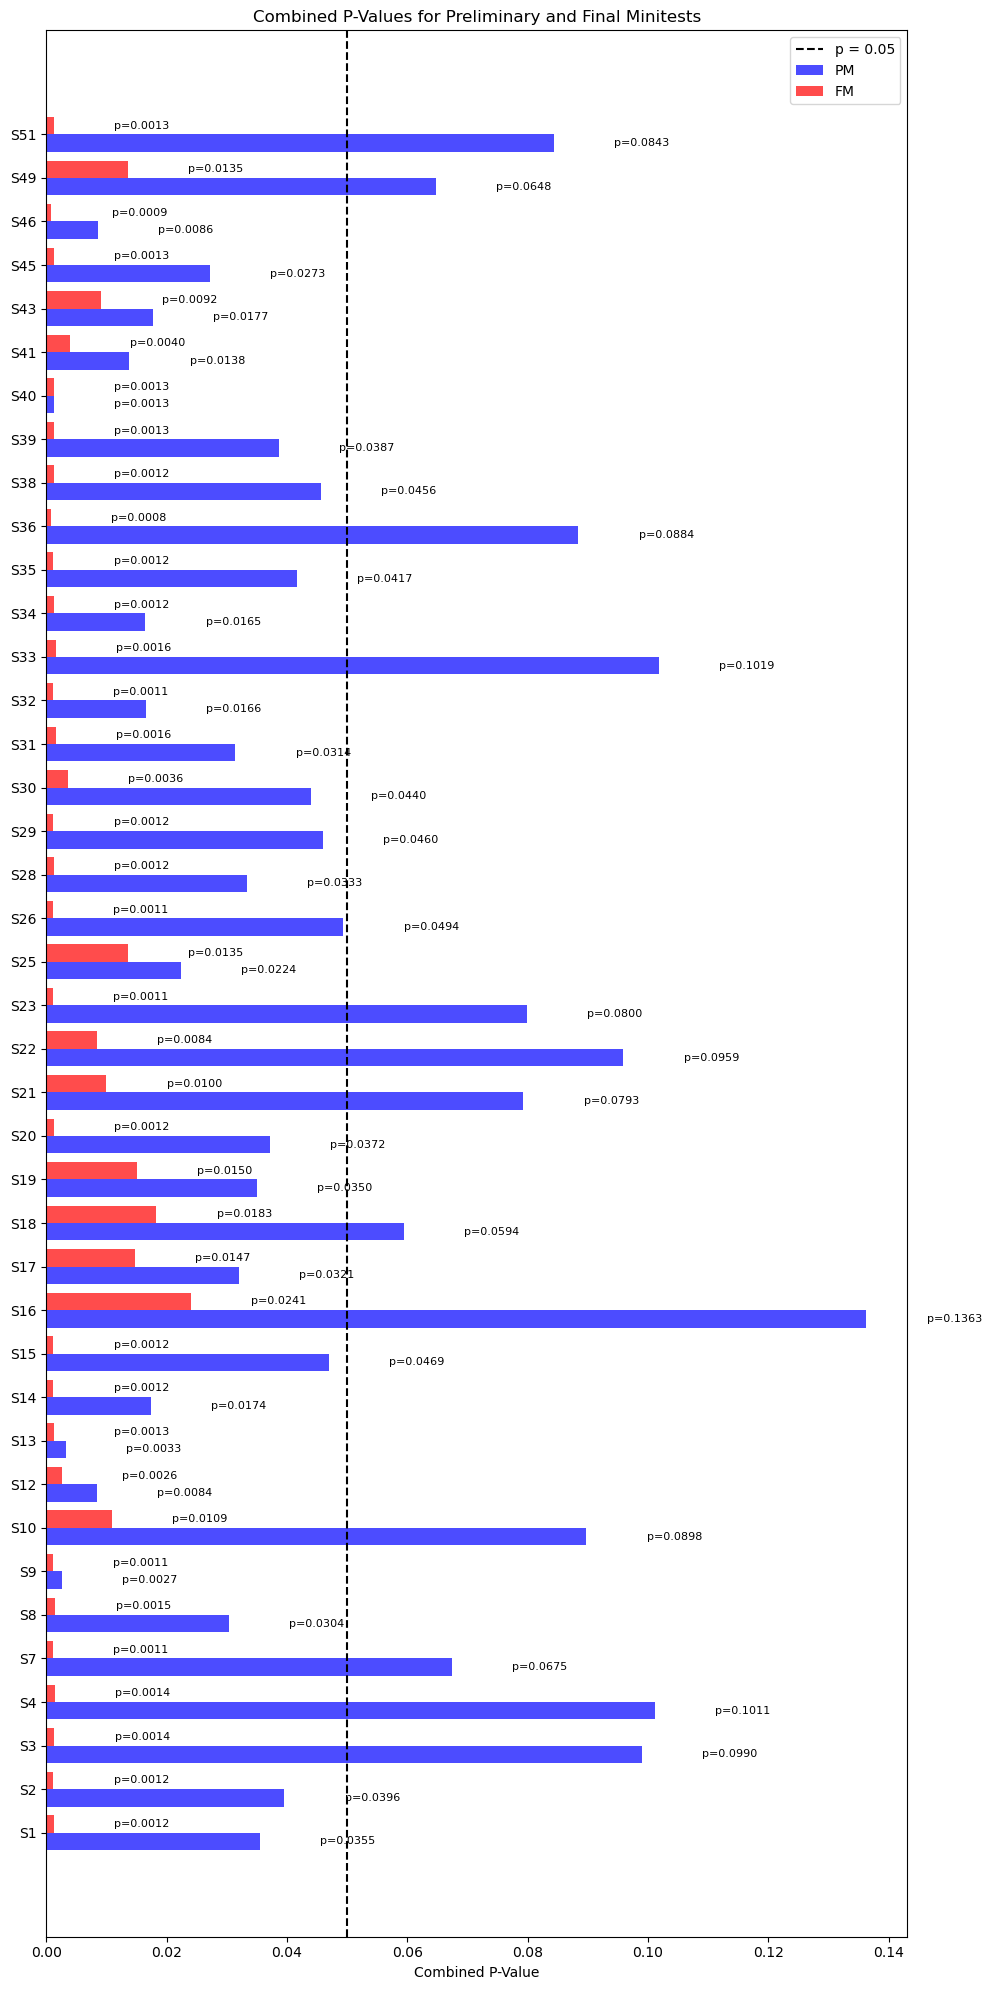

SUBJECT  expected_total      std_dev  Observed_Total_PM    Z_Score_PM   P_Value_PM  Z_Score_PM_NCQ  P_Value_PM_NCQ  Z_Score_PM_CQ  P_Value_PM_CQ  Observed_Total_FM   Z_Score_FM   P_Value_FM  Z_Score_FM_NCQ  P_Value_FM_NCQ  Z_Score_FM_CQ  P_Value_FM_CQ  Combined_P_Value_PM  Combined_P_Value_FM
     S1    0.4753369000 0.1811886575       0.6240000000  0.8204878941 0.1853000000    0.2906534037    0.3499000000  -2.0936018031   0.0165000000       0.8080000000 1.8360040006 0.0285000000    1.8360040006    0.0285000000  -2.6234362935   0.0043000000         0.0355320986         0.0012263568
     S2    0.4383987000 0.1797056697       0.6800000000  1.3444278099 0.1144000000    0.8102209586    0.2298000000  -1.9053305357   0.0286000000       0.8080000000 2.0567036117 0.0163000000    2.0567036117    0.0163000000  -2.4395373870   0.0073000000         0.0395972935         0.0011942397
     S3    0.4372098000 0.1815141851       0.7110000000  1.5083680644 0.0653000000    0.4561087056    0.2953000000  -1

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data():
    # Load and prepare the data
    prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
    pm_df = pd.read_csv('PreliminaryResults_8q.csv')
    fm_df = pd.read_csv('FinalResults_8q.csv')
    
    # Rename columns for easier reference
    prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']
    prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
    pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
    fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

    # Merge dataframes
    data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
    data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

    # Define question values (weights) and indices
    question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])
    ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
    cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

    return data, question_values, ncq_indices, cq_indices

def calculate_p_values(data, question_values, n_simulations=10000):
    results = []
    for _, row in data.iterrows():
        subject_id = row['SUBJECT']
        probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
        obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
        obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

        # Calculate observed totals for PM and FM
        observed_total_pm = np.dot(obs_pm, question_values)
        observed_total_fm = np.dot(obs_fm, question_values)
        
        # Simulate responses to compute expected value and CI
        sim_totals = []
        for _ in range(n_simulations):
            sim_responses = np.random.binomial(1, probs)
            sim_total = np.dot(sim_responses, question_values)
            sim_totals.append(sim_total)
        
        sim_totals = np.array(sim_totals)
        expected_total = np.mean(sim_totals)
        std_dev = np.std(sim_totals)

        # Calculate overall p-values and z-scores for PM and FM
        z_score_pm = (observed_total_pm - expected_total) / std_dev
        p_value_pm = np.mean(sim_totals >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals <= observed_total_pm)
        
        z_score_fm = (observed_total_fm - expected_total) / std_dev
        p_value_fm = np.mean(sim_totals >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals <= observed_total_fm)

        # Store overall results
        results.append({
            'SUBJECT': subject_id,
            'expected_total': expected_total,
            'std_dev': std_dev,
            'Observed_Total_PM': observed_total_pm,
            'Z_Score_PM': z_score_pm,
            'P_Value_PM': p_value_pm,
            'Observed_Total_FM': observed_total_fm,
            'Z_Score_FM': z_score_fm,
            'P_Value_FM': p_value_fm
        })
    
    return pd.DataFrame(results)

def calculate_deviation_rates(results_df):
    # Calculate deviation rates for students and questions
    results_df['student_deviation_rate'] = np.minimum(0.05, results_df['P_Value_PM']) - results_df['P_Value_FM']
    results_df['question_deviation_rate'] = results_df.apply(lambda row: np.minimum(0.05, row['P_Value_PM']) - row['P_Value_FM'], axis=1)
    
    return results_df

def generate_final_deviation_matrix(conformity_matrix, results_df, deviation_rate_col):
    # Create a matrix to store the final deviation values for the heatmap
    final_deviation_matrix = np.zeros_like(conformity_matrix, dtype=float)

    for student_index, row in results_df.iterrows():
        for question_index in range(8):
            if conformity_matrix[student_index][question_index] == 1:
                # Calculate final deviation as the product of student and question deviation rates
                final_deviation_matrix[student_index][question_index] = (
                    row[deviation_rate_col] * row['question_deviation_rate']
                )
    
    return final_deviation_matrix

def plot_deviation_heatmap(final_deviation_matrix, students, questions):
    plt.figure(figsize=(12, 8))
    plt.imshow(final_deviation_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Deviation Rate')
    plt.xticks(ticks=np.arange(len(questions)), labels=questions)
    plt.yticks(ticks=np.arange(len(students)), labels=students)
    plt.title('Deviation Heatmap')
    plt.xlabel('Questions')
    plt.ylabel('Students')
    plt.show()

    

def calculate_and_populate_tables(data, question_values, ncq_indices, cq_indices, n_simulations=10000):
    results = []
    student_results = []

    for _, row in data.iterrows():
        subject_id = row['SUBJECT']
        probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
        obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
        obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

        # Simulate responses to compute expected value and CI
        sim_totals = []
        for _ in range(n_simulations):
            sim_responses = np.random.binomial(1, probs)
            sim_total = np.dot(sim_responses, question_values)
            sim_totals.append(sim_total)
        
        sim_totals = np.array(sim_totals)
        expected_total = np.mean(sim_totals)
        std_dev = np.std(sim_totals)

        # Overall Z-Scores and P-Values
        observed_total_pm = np.dot(obs_pm, question_values)
        z_score_pm = (observed_total_pm - expected_total) / std_dev
        p_value_pm = np.mean(sim_totals >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals <= observed_total_pm)

        observed_total_fm = np.dot(obs_fm, question_values)
        z_score_fm = (observed_total_fm - expected_total) / std_dev
        p_value_fm = np.mean(sim_totals >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals <= observed_total_fm)

        # Calculating Z-Scores and P-Values for NCQ and CQ
        observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
        observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])
        observed_total_fm_ncq = np.dot(obs_fm[ncq_indices], question_values[ncq_indices])
        observed_total_fm_cq = np.dot(obs_fm[cq_indices], question_values[cq_indices])

        # NCQ and CQ simulations
        z_score_pm_ncq = (observed_total_pm_ncq - expected_total) / std_dev
        p_value_pm_ncq = np.mean(sim_totals >= observed_total_pm_ncq) if observed_total_pm_ncq >= expected_total else np.mean(sim_totals <= observed_total_pm_ncq)

        z_score_pm_cq = (observed_total_pm_cq - expected_total) / std_dev
        p_value_pm_cq = np.mean(sim_totals >= observed_total_pm_cq) if observed_total_pm_cq >= expected_total else np.mean(sim_totals <= observed_total_pm_cq)

        z_score_fm_ncq = (observed_total_fm_ncq - expected_total) / std_dev
        p_value_fm_ncq = np.mean(sim_totals >= observed_total_fm_ncq) if observed_total_fm_ncq >= expected_total else np.mean(sim_totals <= observed_total_fm_ncq)

        z_score_fm_cq = (observed_total_fm_cq - expected_total) / std_dev
        p_value_fm_cq = np.mean(sim_totals >= observed_total_fm_cq) if observed_total_fm_cq >= expected_total else np.mean(sim_totals <= observed_total_fm_cq)

        # Calculate Combined P-Values for PM and FM using Fisher's method
        _, combined_p_value_pm = combine_pvalues([p_value_pm_ncq, p_value_pm_cq], method='fisher')
        _, combined_p_value_fm = combine_pvalues([p_value_fm_ncq, p_value_fm_cq], method='fisher')

        # Store the results for each student
        student_results.append({
            'SUBJECT': subject_id,
            'expected_total': expected_total,
            'std_dev': std_dev,
            'Observed_Total_PM': observed_total_pm,
            'Z_Score_PM': z_score_pm,
            'P_Value_PM': p_value_pm,
            'Z_Score_PM_NCQ': z_score_pm_ncq,
            'P_Value_PM_NCQ': p_value_pm_ncq,
            'Z_Score_PM_CQ': z_score_pm_cq,
            'P_Value_PM_CQ': p_value_pm_cq,
            'Observed_Total_FM': observed_total_fm,
            'Z_Score_FM': z_score_fm,
            'P_Value_FM': p_value_fm,
            'Z_Score_FM_NCQ': z_score_fm_ncq,
            'P_Value_FM_NCQ': p_value_fm_ncq,
            'Z_Score_FM_CQ': z_score_fm_cq,
            'P_Value_FM_CQ': p_value_fm_cq,
            'Combined_P_Value_PM': combined_p_value_pm,
            'Combined_P_Value_FM': combined_p_value_fm
        })

    # Convert the list of dictionaries to DataFrame
    student_results_df = pd.DataFrame(student_results)
    return student_results_df

def plot_combined_pvalues(data):
    """
    This function generates a bar plot for each student with combined p-values for PM and FM.
    The blue bar represents the PM combined p-value, and the red bar represents the FM combined p-value.
    A dotted line indicates the 0.05 threshold for significance.
    
    Parameters:
    - data: A DataFrame containing columns 'SUBJECT', 'Combined_P_Value_PM', and 'Combined_P_Value_FM'.
    """
    # Define the p-value threshold
    p_value_threshold = 0.05
    
    # Sort data by Combined_P_Value_PM to have a consistent order in the plot
    # data = data.sort_values('Combined_P_Value_PM', ascending=False)
    
    # Number of students
    n_students = len(data)
    
    # Create the plot
    plt.figure(figsize=(10, n_students * 0.5))  # Adjust height based on number of students
    y_positions = np.arange(n_students)
    
    # Plotting the combined p-values
    plt.barh(y_positions, data['Combined_P_Value_PM'], color='blue', alpha=0.7, height=0.4, label='PM')
    plt.barh(y_positions + 0.4, data['Combined_P_Value_FM'], color='red', alpha=0.7, height=0.4, label='FM')
    
    # Add the significance threshold line
    plt.axvline(p_value_threshold, color='black', linestyle='--', label=f'p = {p_value_threshold}')
    
    # Annotate each bar with its p-value
    for i, (pm, fm) in enumerate(zip(data['Combined_P_Value_PM'], data['Combined_P_Value_FM'])):
        plt.text(pm + 0.01, y_positions[i], f'p={pm:.4f}', va='center', ha='left', fontsize=8, color='black')
        plt.text(fm + 0.01, y_positions[i] + 0.4, f'p={fm:.4f}', va='center', ha='left', fontsize=8, color='black')
    
    # Labels and legend
    plt.xlabel('Combined P-Value')
    plt.yticks(y_positions + 0.2, data['SUBJECT'])
    plt.title('Combined P-Values for Preliminary and Final Minitests')
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming `results_df` is the DataFrame produced by `calculate_and_populate_tables`
# plot_combined_pvalues(results_df)



# Main Program Execution
if __name__ == "__main__":
    data, question_values, ncq_indices, cq_indices = load_data()
    results_df = calculate_p_values(data, question_values)
    results_df = calculate_deviation_rates(results_df)


    # Conformity matrix example: replace with actual conformity data
    conformity_matrix = np.random.choice([0, 1, -1], size=(len(results_df), 8), p=[0.7, 0.2, 0.1])
    
    final_deviation_matrix = generate_final_deviation_matrix(conformity_matrix, results_df, 'student_deviation_rate')
    
    students = results_df['SUBJECT'].tolist()
    questions = [f'Q{num}' for num in range(1, 9)]
    
    plot_deviation_heatmap(final_deviation_matrix, students, questions)
    
    # Step 2: Calculate Z-Scores and P-Values for PM and FM, and populate the tables
    results_df = calculate_and_populate_tables(data, question_values, ncq_indices, cq_indices)

    
    plot_combined_pvalues(results_df)
    
    # Display the resulting DataFrame
    print(results_df.to_string(index=False))
    

# THIS IS A GOOD VERSION FOR OBTAINING THE TABLE PER STUDENT:



In [36]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student
n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Calculate expected totals, variance, and standard deviation for overall PM and FM
    expected_total = np.sum(probs * question_values)
    variances = probs * (1 - probs) * (question_values ** 2)
    std_dev = np.sqrt(variances.sum())

    # Calculate Z-Scores for overall PM and FM
    z_score_pm = (observed_total_pm - expected_total) / std_dev
    z_score_fm = (observed_total_fm - expected_total) / std_dev

    # Calculate expected totals, variance, and standard deviation for NCQ and CQ separately
    expected_ncq = np.sum(probs[ncq_indices] * question_values[ncq_indices])
    variance_ncq = np.sum(probs[ncq_indices] * (1 - probs[ncq_indices]) * (question_values[ncq_indices] ** 2))
    std_dev_ncq = np.sqrt(variance_ncq)

    expected_cq = np.sum(probs[cq_indices] * question_values[cq_indices])
    variance_cq = np.sum(probs[cq_indices] * (1 - probs[cq_indices]) * (question_values[cq_indices] ** 2))
    std_dev_cq = np.sqrt(variance_cq)

    # Calculate observed totals for NCQ and CQ in PM
    observed_total_pm_ncq = np.dot(obs_pm[ncq_indices], question_values[ncq_indices])
    observed_total_pm_cq = np.dot(obs_pm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ in PM
    z_score_pm_ncq = (observed_total_pm_ncq - expected_ncq) / std_dev
    z_score_pm_cq = (observed_total_pm_cq - expected_cq) / std_dev

    # Calculate observed totals for NCQ and CQ in FM
    observed_total_fm_ncq = np.dot(obs_fm[ncq_indices], question_values[ncq_indices])
    observed_total_fm_cq = np.dot(obs_fm[cq_indices], question_values[cq_indices])

    # Calculate Z-Scores for NCQ and CQ in FM
    z_score_fm_ncq = (observed_total_fm_ncq - expected_ncq) / std_dev
    z_score_fm_cq = (observed_total_fm_cq - expected_cq) / std_dev

    # Monte Carlo simulation for p-values
    sim_totals_pm = []
    sim_totals_fm = []
    sim_totals_pm_ncq = []
    sim_totals_pm_cq = []
    sim_totals_fm_ncq = []
    sim_totals_fm_cq = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_total_ncq = np.dot(sim_responses[ncq_indices], question_values[ncq_indices])
        sim_total_cq = np.dot(sim_responses[cq_indices], question_values[cq_indices])

        sim_totals_pm.append(sim_total)
        sim_totals_fm.append(sim_total)
        sim_totals_pm_ncq.append(sim_total_ncq)
        sim_totals_pm_cq.append(sim_total_cq)
        sim_totals_fm_ncq.append(sim_total_ncq)
        sim_totals_fm_cq.append(sim_total_cq)

    # Convert simulation results to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)
    sim_totals_pm_ncq = np.array(sim_totals_pm_ncq)
    sim_totals_pm_cq = np.array(sim_totals_pm_cq)
    sim_totals_fm_ncq = np.array(sim_totals_fm_ncq)
    sim_totals_fm_cq = np.array(sim_totals_fm_cq)

    # Calculate p-values for PM and FM (Overall, NCQ, and CQ)
    p_value_pm = np.mean(sim_totals_pm >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals_pm <= observed_total_pm)
    p_value_fm = np.mean(sim_totals_fm >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals_fm <= observed_total_fm)
    p_value_pm_ncq = np.mean(sim_totals_pm_ncq >= observed_total_pm_ncq) if observed_total_pm_ncq >= expected_ncq else np.mean(sim_totals_pm_ncq <= observed_total_pm_ncq)
    p_value_pm_cq = np.mean(sim_totals_pm_cq >= observed_total_pm_cq) if observed_total_pm_cq >= expected_cq else np.mean(sim_totals_pm_cq <= observed_total_pm_cq)
    p_value_fm_ncq = np.mean(sim_totals_fm_ncq >= observed_total_fm_ncq) if observed_total_fm_ncq >= expected_ncq else np.mean(sim_totals_fm_ncq <= observed_total_fm_ncq)
    p_value_fm_cq = np.mean(sim_totals_fm_cq >= observed_total_fm_cq) if observed_total_fm_cq >= expected_cq else np.mean(sim_totals_fm_cq <= observed_total_fm_cq)

    # Calculate combined p-values using Fisher's method
    def calculate_combined_p_value(p_value_ncq, p_value_cq):
        fisher_statistic = -2 * (np.log(p_value_ncq) + np.log(p_value_cq))
        combined_p_value = 1 - chi2.cdf(fisher_statistic, df=4)  # df = 2*number_of_tests
        return combined_p_value
    
    combined_p_value_pm = calculate_combined_p_value(p_value_pm_ncq, p_value_pm_cq)
    combined_p_value_fm = calculate_combined_p_value(p_value_fm_ncq, p_value_fm_cq)

    # Store results
    results.append({
        'SUBJECT': subject_id,
        'expected_total': expected_total,
        'std_dev': std_dev,
        'Observed_Total_PM': observed_total_pm,
        'Z_Score_PM': z_score_pm,
        'Z_Score_PM_NCQ': z_score_pm_ncq,
        'Z_Score_PM_CQ': z_score_pm_cq,
        'Observed_Total_FM': observed_total_fm,
        'Z_Score_FM': z_score_fm,
        'Z_Score_FM_NCQ': z_score_fm_ncq,
        'Z_Score_FM_CQ': z_score_fm_cq,
        'P_Value_PM': p_value_pm,
        'P_Value_PM_NCQ': p_value_pm_ncq,
        'P_Value_PM_CQ': p_value_pm_cq,
        'P_Value_FM': p_value_fm,
        'P_Value_FM_NCQ': p_value_fm_ncq,
        'P_Value_FM_CQ': p_value_fm_cq,
        'Combined_P_Value_PM': combined_p_value_pm,
        'Combined_P_Value_FM': combined_p_value_fm
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))


SUBJECT  expected_total  std_dev  Observed_Total_PM  Z_Score_PM  Z_Score_PM_NCQ  Z_Score_PM_CQ  Observed_Total_FM  Z_Score_FM  Z_Score_FM_NCQ  Z_Score_FM_CQ  P_Value_PM  P_Value_PM_NCQ  P_Value_PM_CQ  P_Value_FM  P_Value_FM_NCQ  P_Value_FM_CQ  Combined_P_Value_PM  Combined_P_Value_FM
     S1        0.475671 0.181029              0.624    0.819366        0.945904      -0.126538              0.808    1.835778        2.492618      -0.656840      0.1941          0.1512         0.6110      0.0307          0.0086         0.1424             0.312422             0.009436
     S2        0.436587 0.180760              0.680    1.346612        1.388352      -0.041741              0.808    2.054735        2.627568      -0.572833      0.1190          0.1062         0.7108      0.0169          0.0051         0.2039             0.270530             0.008183
     S3        0.440546 0.180819              0.711    1.495715        1.022082       0.473633              0.808    2.032163        2.614833    

# With plot

# IMPORTANT: THIS SHOULD BE RUN AFTER THE PREVIOUS'S BEEN EXECUTED

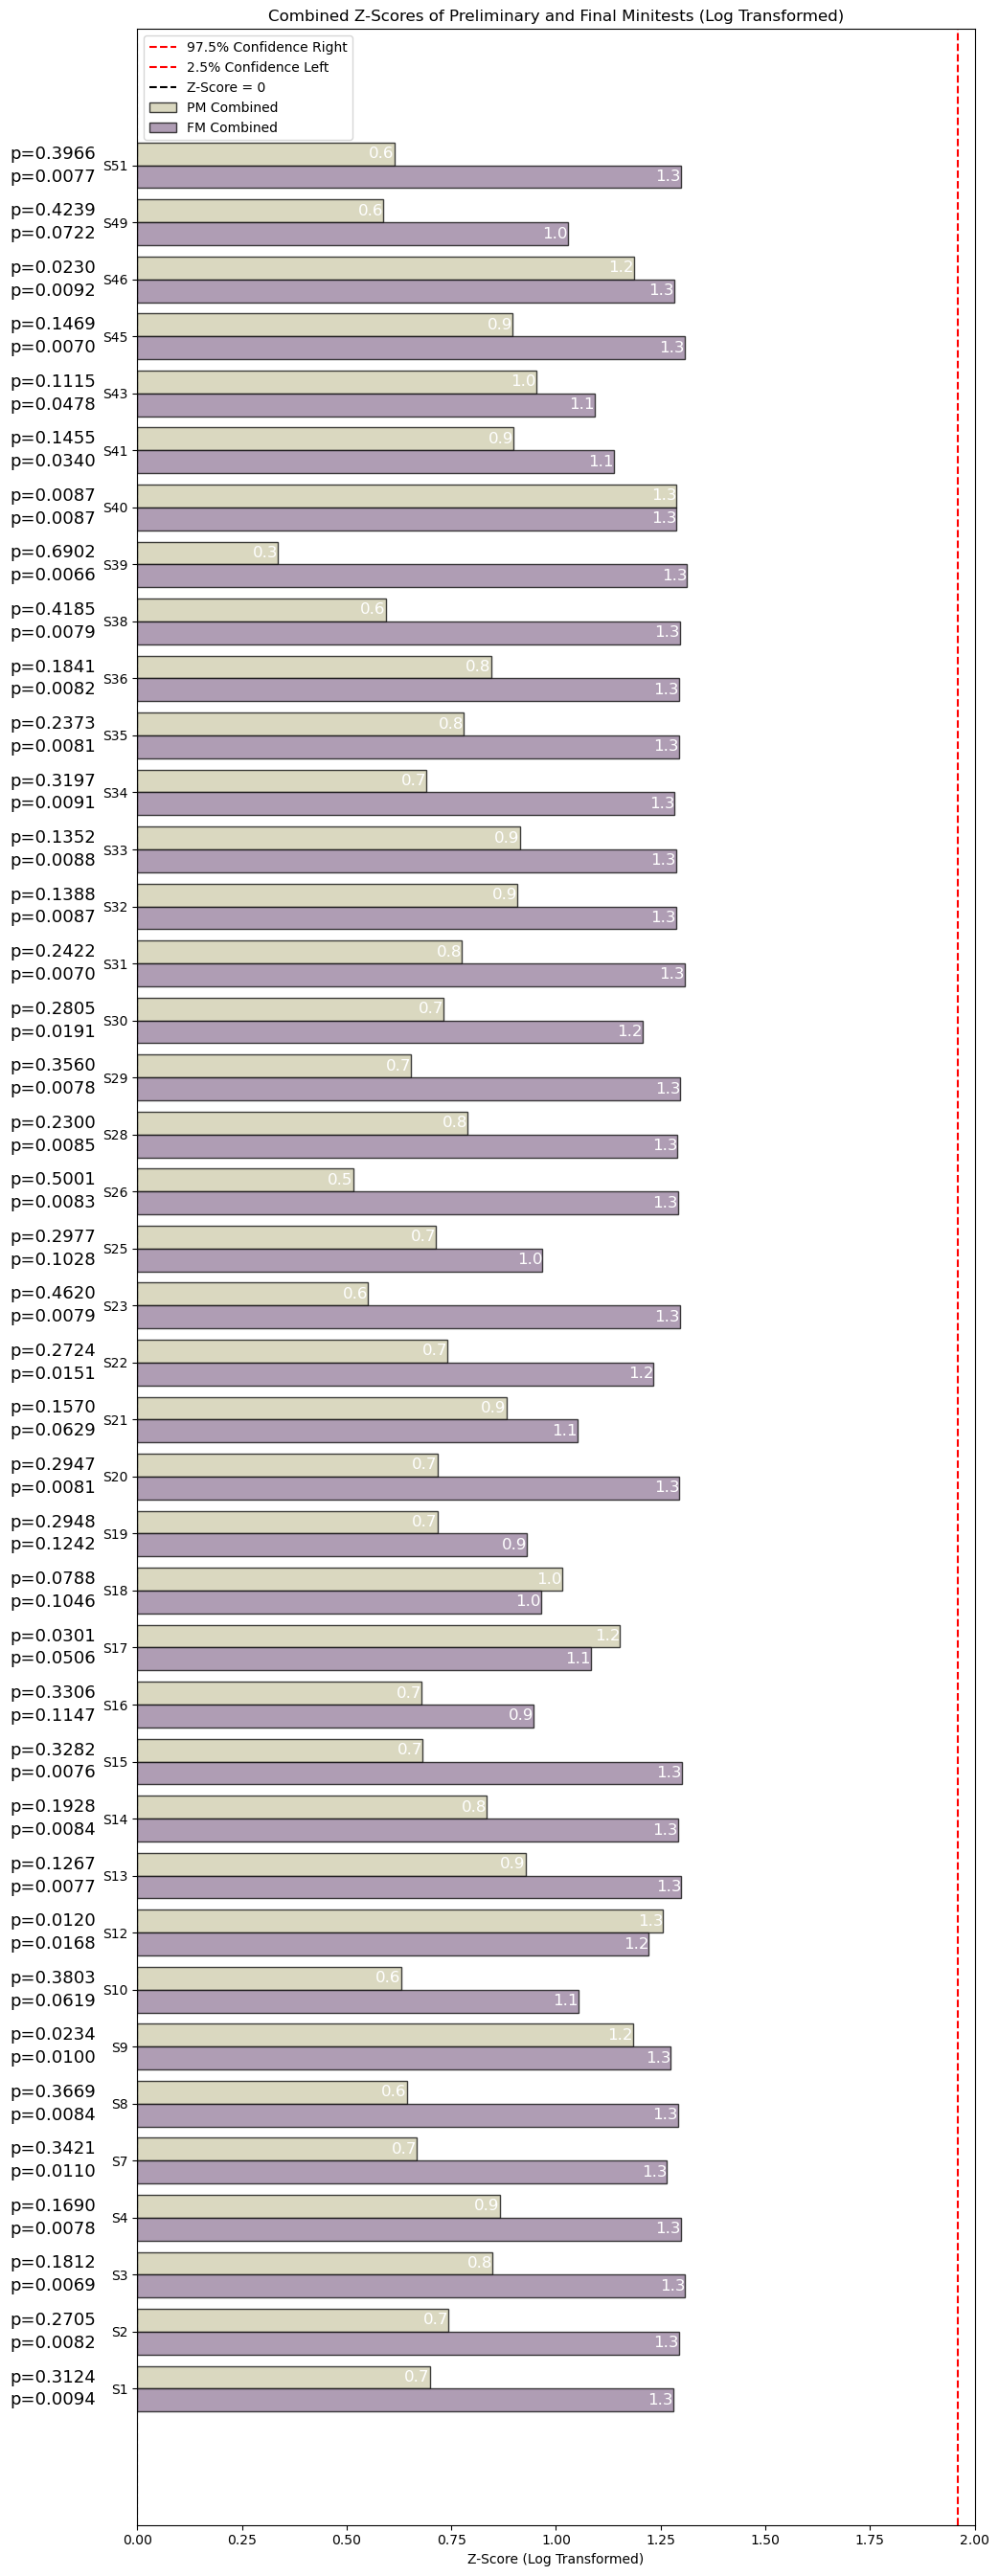

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the previous results
results_df = pd.DataFrame(results)  # Assuming you are building on the previous results

# Step 1: Calculate Z-Scores from Combined P-Values
def calculate_z_score(p_value):
    # Convert p-value to corresponding Z-score
    return norm.ppf(1 - p_value / 2) if p_value < 1 else 0

# Add the Z-scores calculated from the combined p-values for PM and FM
results_df['Z_Score_PM_Combined'] = results_df['Combined_P_Value_PM'].apply(calculate_z_score)
results_df['Z_Score_FM_Combined'] = results_df['Combined_P_Value_FM'].apply(calculate_z_score)

# Apply log transformation to Z-Scores for better visual comparison
def transform_z_score(z):
    # Apply symmetric log transformation with linthresh of 0.1
    return np.sign(z) * (np.log1p(np.abs(z)))

results_df['Z_Score_PM_Combined_Transformed'] = results_df['Z_Score_PM_Combined'].apply(transform_z_score)
results_df['Z_Score_FM_Combined_Transformed'] = results_df['Z_Score_FM_Combined'].apply(transform_z_score)

# Step 2: Plot the Z-Scores with Combined P-Values
fig, ax = plt.subplots(figsize=(10.5, 27))  # Increase size by 150% proportionally

subjects = results_df['SUBJECT']
z_scores_pm_combined = results_df['Z_Score_PM_Combined_Transformed']
z_scores_fm_combined = results_df['Z_Score_FM_Combined_Transformed']
p_values_pm = results_df['Combined_P_Value_PM']
p_values_fm = results_df['Combined_P_Value_FM']

bar_width = 0.4
y_positions = np.arange(len(subjects))

# Create a horizontal bar plot for Z-Scores
ax.barh(y_positions + bar_width, z_scores_pm_combined, bar_width, label='PM Combined', color='#D1CFB1', edgecolor='#111111', alpha=0.8)
ax.barh(y_positions, z_scores_fm_combined, bar_width, label='FM Combined', color='#9B85A2', edgecolor='#111111', alpha=0.8)

# Step 3: Add confidence intervals (97.5% and 2.5% thresholds)
upper_threshold = norm.ppf(0.975)  # 97.5% confidence (z = ~1.96)
lower_threshold = -upper_threshold  # 2.5% confidence (z = ~-1.96)

# Add vertical lines for 95% confidence intervals
ax.axvline(upper_threshold, color='red', linestyle='--', label='97.5% Confidence Right')
ax.axvline(lower_threshold, color='red', linestyle='--', label='2.5% Confidence Left')
ax.axvline(0, color='black', linestyle='--', label='Z-Score = 0')

# Step 4: Add p-values and z-scores
for i, (pm_z, fm_z, p_pm, p_fm) in enumerate(zip(z_scores_pm_combined, z_scores_fm_combined, p_values_pm, p_values_fm)):
    # Add p-values on the left side for PM and FM, shifting slightly left to avoid overlap with the axis
    ax.text(-0.1, i + bar_width, f'p={p_pm:.4f}', ha='right', va='center', fontsize=13, color='black')
    ax.text(-0.1, i, f'p={p_fm:.4f}', ha='right', va='center', fontsize=13, color='black')

    # Add z-scores inside the bars
    ax.text(pm_z, i + bar_width, f'{pm_z:.1f}', ha='right', va='center', fontsize=12, color='white')
    ax.text(fm_z, i, f'{fm_z:.1f}', ha='right', va='center', fontsize=12, color='white')

# Formatting the plot
ax.set_xlim(0, 2.0)  # Set the x-axis to start from 0
ax.set_yticks(y_positions + bar_width / 2)
ax.set_yticklabels(subjects)
ax.set_xlabel('Z-Score (Log Transformed)')
ax.set_title('Combined Z-Scores of Preliminary and Final Minitests (Log Transformed)')
ax.legend()

plt.tight_layout()
plt.show()


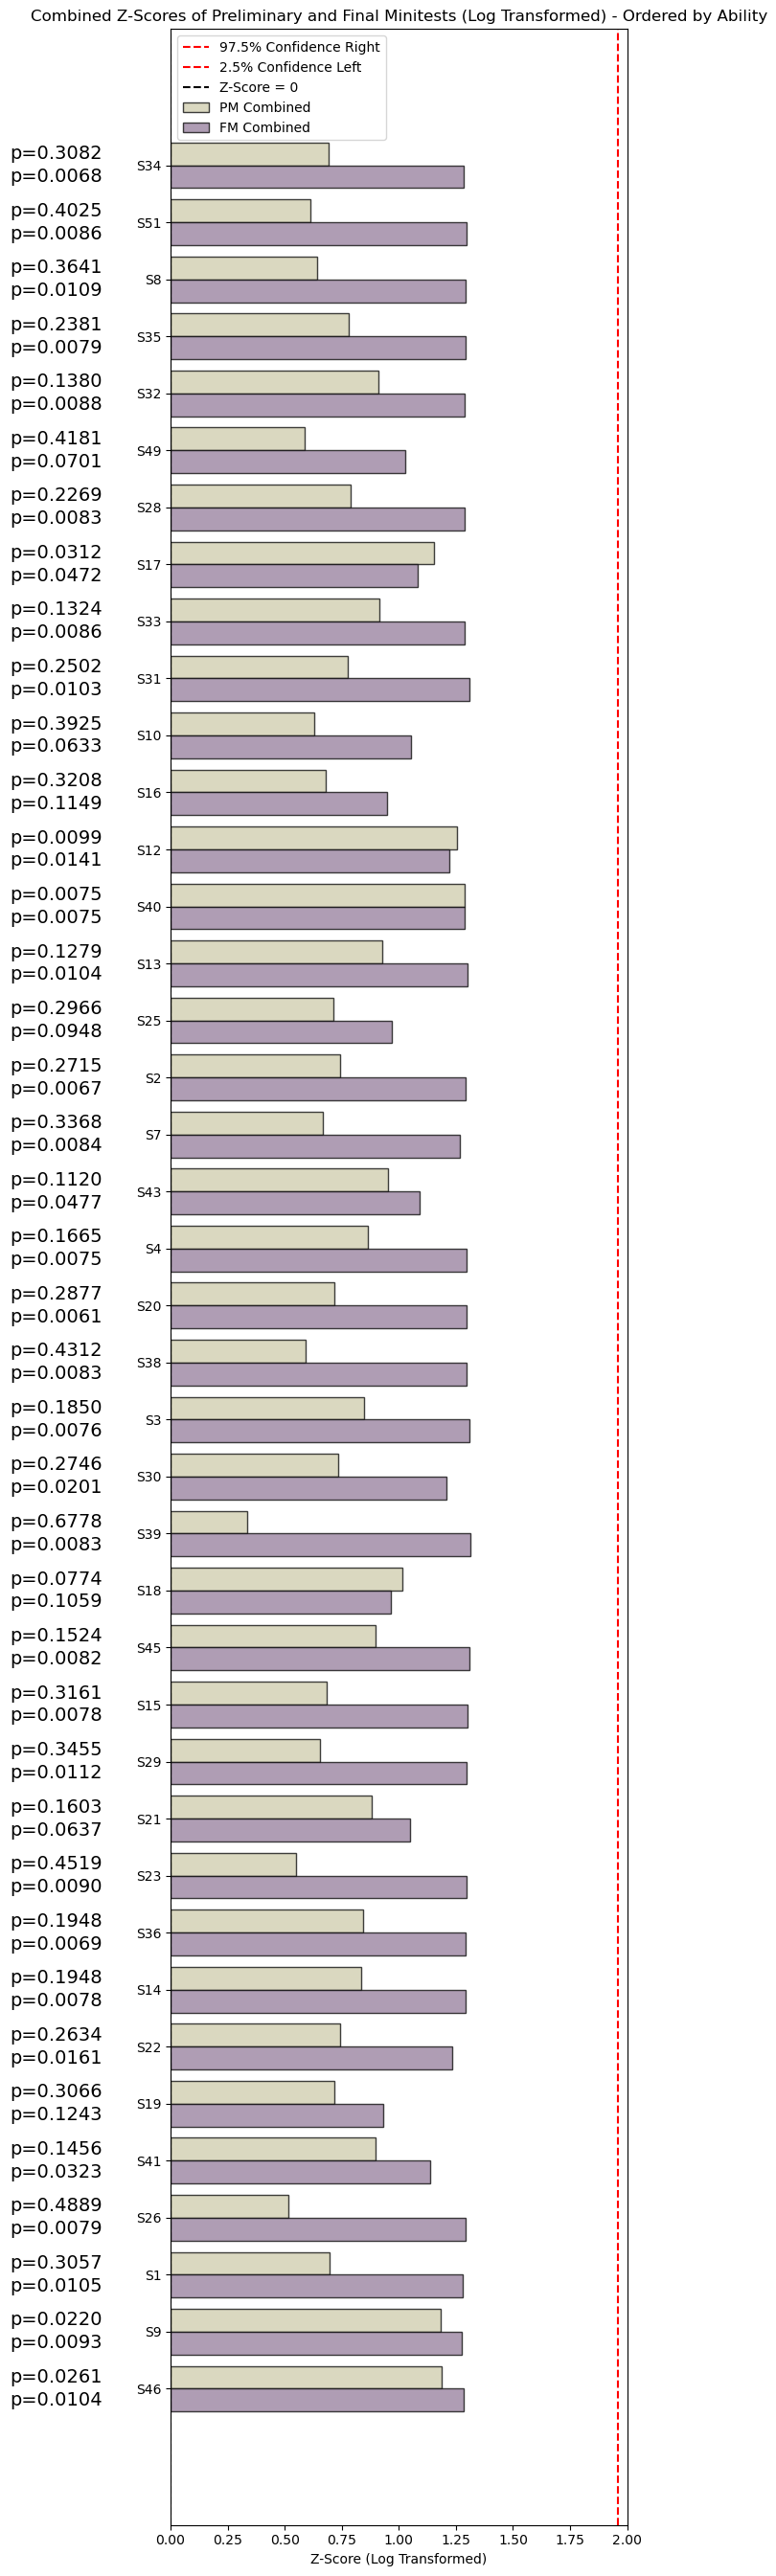

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the previous results
results_df = pd.DataFrame(results)  # Assuming you are building on the previous results

# Array of abilities corresponding to each student
abilities = np.array([
    0.2411, 0.0467, 0.0725, 0.0500, 0.0483, -0.0799, 0.2508, 0.0218, 0.0257, 0.0299, 
    0.1773, 0.0993, 0.0250, -0.0247, 0.0880, 0.1990, 0.0583, 0.1314, 0.1949, 0.1636, 
    0.0401, 0.2143, -0.0260, 0.1113, 0.0729, 0.0177, -0.0317, -0.0173, -0.1089, -0.0461, 
    0.1750, 0.0702, 0.0798, 0.0277, 0.2054, 0.0496, 0.0908, 0.2683, -0.0272, -0.1002
])
# Replace with the provided visualisation values for PM and FM
visual_p_values_pm = np.array([0.3082, 0.4025, 0.3641, 0.2381, 0.1380, 0.4181, 0.2269, 
                               0.0312, 0.1324, 0.2502, 0.3925, 0.3208, 0.0099, 0.0075,
                               0.1279, 0.2966, 0.2715, 0.3368, 0.1120, 0.1665, 0.2877, 
                               0.4312, 0.1850, 0.2746, 0.6778, 0.0774, 0.1524, 0.3161, 
                               0.3455, 0.1603, 0.4519, 0.1948, 0.1948, 0.2634, 0.3066, 
                               0.1456, 0.4889, 0.3057, 0.0220, 0.0261])

visual_p_values_fm = np.array([0.0068, 0.0086, 0.0109, 0.0079, 0.0088, 0.0701, 0.0083, 
                               0.0472, 0.0086, 0.0103, 0.0633, 0.1149, 0.0141, 0.0075, 
                               0.0104, 0.0948, 0.0067, 0.0084, 0.0477, 0.0075, 0.0061, 
                               0.0083, 0.0076, 0.0201, 0.0083, 0.1059, 0.0082, 0.0078, 
                               0.0112, 0.0637, 0.0090, 0.0069, 0.0078, 0.0161, 0.1243, 
                               0.0323, 0.0079, 0.0105, 0.0093, 0.0104])
visual_p_values_pm = visual_p_values_pm[::-1]
visual_p_values_fm = visual_p_values_fm[::-1]
# Adding the abilities to the results DataFrame
results_df['Ability'] = abilities

# Sort the DataFrame by abilities in ascending order
results_df = results_df.sort_values(by='Ability', ascending=False)
#results_df = results_df.sort_values(by='Ability')

# Sort visual p-values accordingly (since they correspond to the initial order)
#sorted_visual_p_values_pm = [x for _, x in sorted(zip(abilities, visual_p_values_pm))]
#sorted_visual_p_values_fm = [x for _, x in sorted(zip(abilities, visual_p_values_fm))]

# Step 1: Calculate Z-Scores from Combined P-Values
def calculate_z_score(p_value):
    # Convert p-value to corresponding Z-score
    return norm.ppf(1 - p_value / 2) if p_value < 1 else 0

# Add the Z-scores calculated from the combined p-values for PM and FM
results_df['Z_Score_PM_Combined'] = results_df['Combined_P_Value_PM'].apply(calculate_z_score)
results_df['Z_Score_FM_Combined'] = results_df['Combined_P_Value_FM'].apply(calculate_z_score)

# Apply log transformation to Z-Scores for better visual comparison
def transform_z_score(z):
    # Apply symmetric log transformation with linthresh of 0.1
    return np.sign(z) * (np.log1p(np.abs(z)))

results_df['Z_Score_PM_Combined_Transformed'] = results_df['Z_Score_PM_Combined'].apply(transform_z_score)
results_df['Z_Score_FM_Combined_Transformed'] = results_df['Z_Score_FM_Combined'].apply(transform_z_score)

# Step 2: Plot the Z-Scores with Combined P-Values
fig, ax = plt.subplots(figsize=(7, 27))  # Increase size by 150% proportionally

subjects = results_df['SUBJECT']
z_scores_pm_combined = results_df['Z_Score_PM_Combined_Transformed']
z_scores_fm_combined = results_df['Z_Score_FM_Combined_Transformed']
p_values_pm = results_df['Combined_P_Value_PM']
p_values_fm = results_df['Combined_P_Value_FM']

bar_width = 0.4
y_positions = np.arange(len(subjects))

# Create a horizontal bar plot for Z-Scores
ax.barh(y_positions + bar_width, z_scores_pm_combined, bar_width, label='PM Combined', color='#D1CFB1', edgecolor='#111111', alpha=0.8)
ax.barh(y_positions, z_scores_fm_combined, bar_width, label='FM Combined', color='#9B85A2', edgecolor='#111111', alpha=0.8)

# Step 3: Add confidence intervals (97.5% and 2.5% thresholds)
upper_threshold = norm.ppf(0.975)  # 97.5% confidence (z = ~1.96)
lower_threshold = -upper_threshold  # 2.5% confidence (z = ~-1.96)

# Add vertical lines for 95% confidence intervals
ax.axvline(upper_threshold, color='red', linestyle='--', label='97.5% Confidence Right')
ax.axvline(lower_threshold, color='red', linestyle='--', label='2.5% Confidence Left')
ax.axvline(0, color='black', linestyle='--', label='Z-Score = 0')

# Step 4: Add p-values and z-scores
for i, (pm_z, fm_z, p_pm, p_fm) in enumerate(zip(z_scores_pm_combined, z_scores_fm_combined, visual_p_values_pm, visual_p_values_fm)):
    # Add p-values on the left side for PM and FM, shifting slightly left to avoid overlap with the axis
    ax.text(-0.3, i + bar_width, f'p={p_pm:.4f}', ha='right', va='center', fontsize=14, color='black')
    ax.text(-0.3, i, f'p={p_fm:.4f}', ha='right', va='center', fontsize=14, color='black')

    # Add z-scores inside the bars
    #ax.text(pm_z, i + bar_width, f'{pm_z:.1f}', ha='right', va='center', fontsize=12, color='white')
    #ax.text(fm_z, i, f'{fm_z:.1f}', ha='right', va='center', fontsize=12, color='white')

# Formatting the plot
ax.set_xlim(0, 2.0)  # Set the x-axis to start from 0
ax.set_yticks(y_positions + bar_width / 2)
ax.set_yticklabels(subjects)
ax.set_xlabel('Z-Score (Log Transformed)')
ax.set_title('Combined Z-Scores of Preliminary and Final Minitests (Log Transformed) - Ordered by Ability')
ax.legend()

plt.tight_layout()
plt.show()


# BACKUP OF VISUALISATION

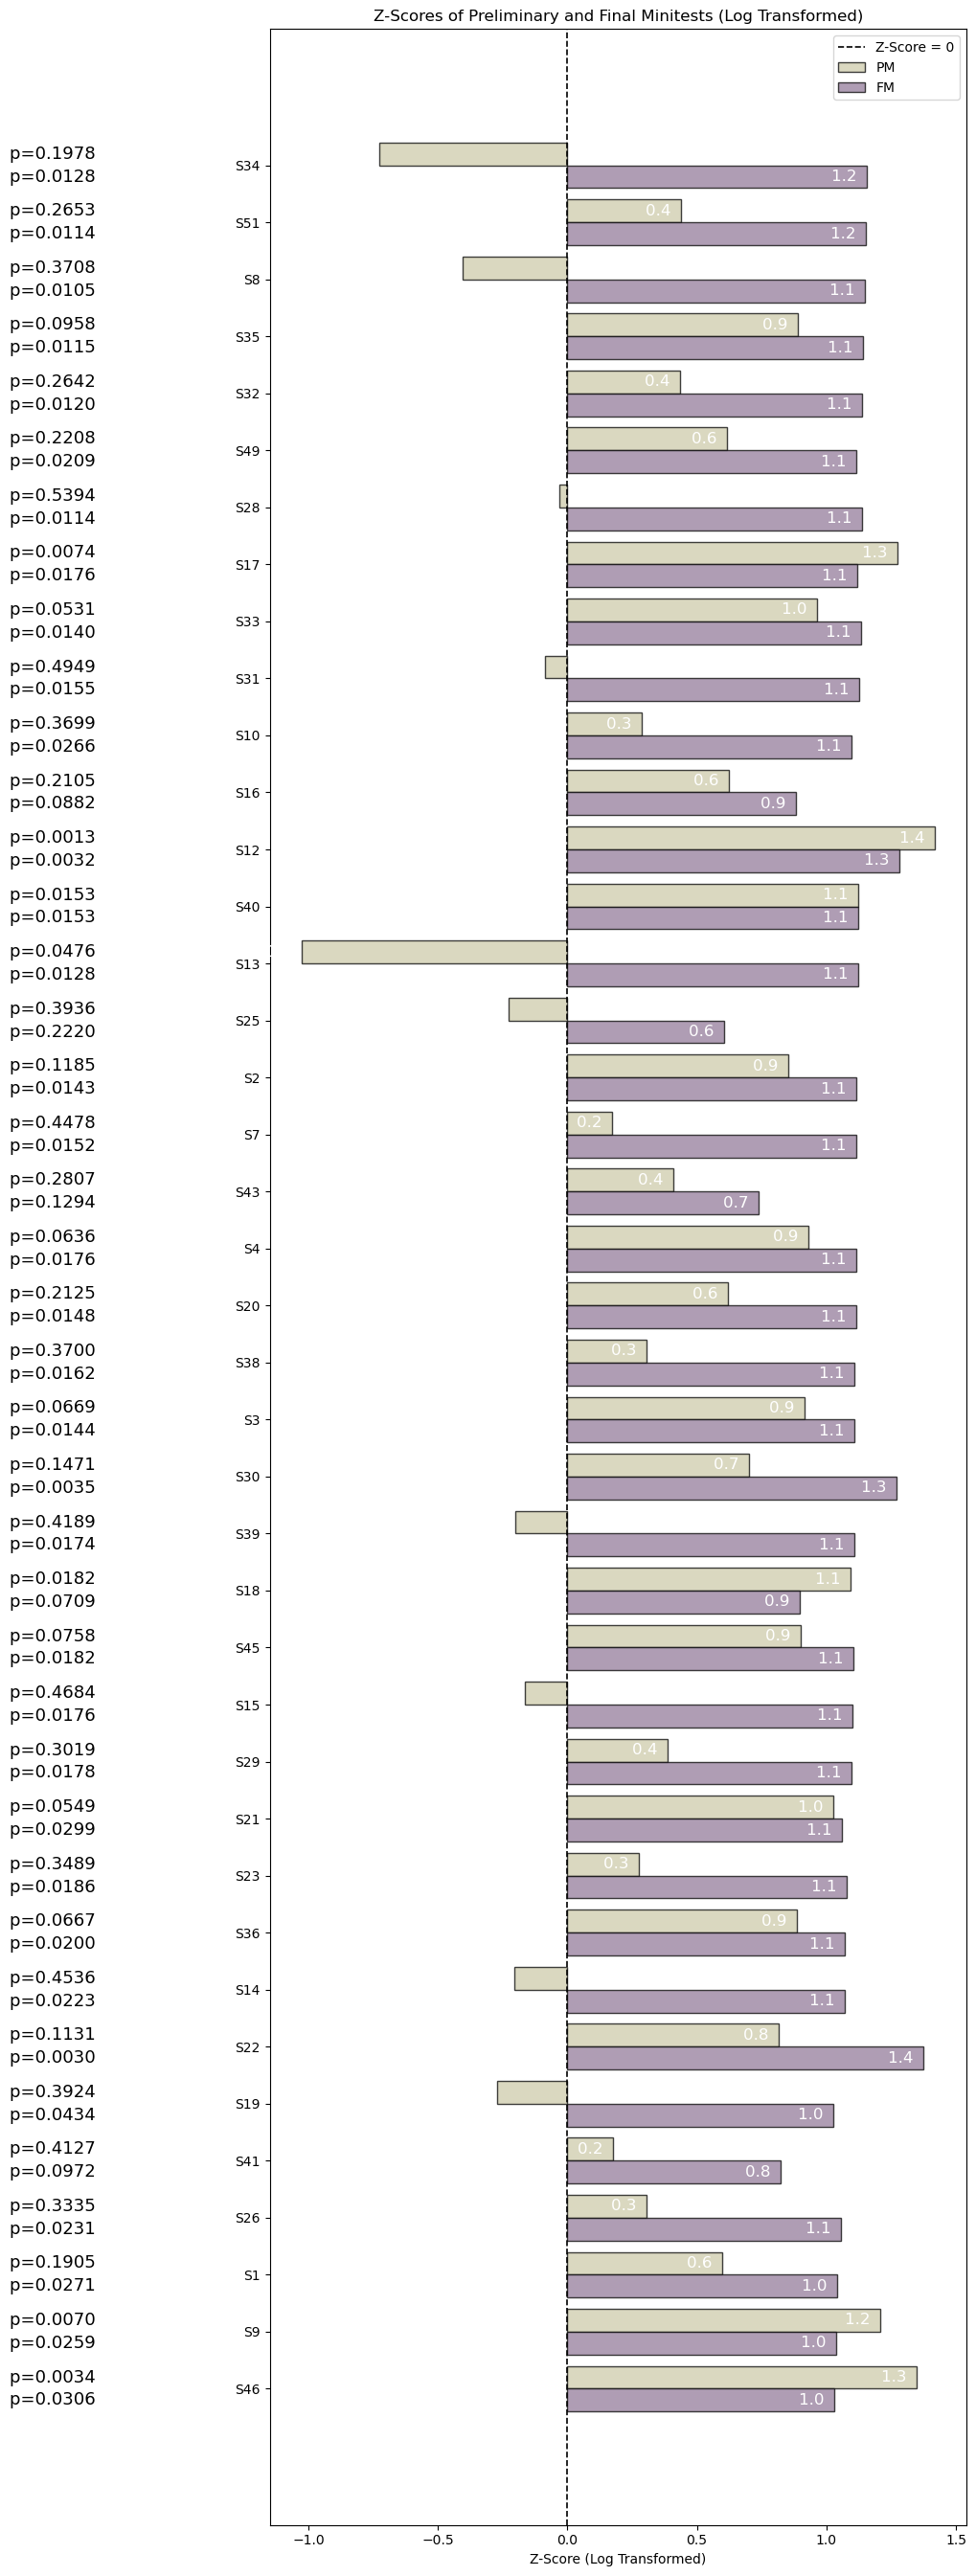

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Step 1: Read the Data
prob_df = pd.read_csv('PreliminaryProbabilities_8q.csv')
pm_df = pd.read_csv('PreliminaryResults_8q.csv')
fm_df = pd.read_csv('FinalResults_8q.csv')

# Rename the columns in the probability dataframe
prob_df.columns = ['SUBJECT', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']

# Ensure that the subject identifiers are consistent across dataframes
prob_df['SUBJECT'] = prob_df['SUBJECT'].str.strip()
pm_df['SUBJECT'] = pm_df['SUBJECT'].str.strip()
fm_df['SUBJECT'] = fm_df['SUBJECT'].str.strip()

# Merge the dataframes to align the data
data = prob_df.merge(pm_df, on='SUBJECT', suffixes=('_prob', '_pm'))
data = data.merge(fm_df, on='SUBJECT', suffixes=('', '_fm'))

# Student abilities (provided values, in order from S1 to S51)
abilities = np.array([
    0.2411, 0.0467, 0.0725, 0.0500, 0.0483, -0.0799, 0.2508, 0.0218, 0.0257, 0.0299, 
    0.1773, 0.0993, 0.0250, -0.0247, 0.0880, 0.1990, 0.0583, 0.1314, 0.1949, 0.1636, 
    0.0401, 0.2143, -0.0260, 0.1113, 0.0729, 0.0177, -0.0317, -0.0173, -0.1089, -0.0461, 
    0.1750, 0.0702, 0.0798, 0.0277, 0.2054, 0.0496, 0.0908, 0.2683, -0.0272, -0.1002
])

# Question values (weights for each question)
question_values = np.array([0.110, 0.106, 0.095, 0.174, 0.114, 0.108, 0.096, 0.196])

# Define Critical and Non-Critical Questions
ncq_indices = [0, 1, 3, 4, 5, 7]  # Indices for Non-Critical Questions (Q1, Q2, Q4, Q5, Q6, Q8)
cq_indices = [2, 6]  # Indices for Critical Questions (Q3, Q7)

# Step 2: Monte Carlo Simulation for Each Student
n_simulations = 10000
results = []

for index, row in data.iterrows():
    subject_id = row['SUBJECT']
    
    # Extract probabilities for the simulation
    probs = row[['Q1_prob', 'Q2_prob', 'Q3_prob', 'Q4_prob', 'Q5_prob', 'Q6_prob', 'Q7_prob', 'Q8_prob']].values.astype(float)
    obs_pm = row[['Q1_pm', 'Q2_pm', 'Q3_pm', 'Q4_pm', 'Q5_pm', 'Q6_pm', 'Q7_pm', 'Q8_pm']].values.astype(int)
    obs_fm = row[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']].values.astype(int)

    # Calculate observed total performance scores for PM and FM
    observed_total_pm = np.dot(obs_pm, question_values)
    observed_total_fm = np.dot(obs_fm, question_values)

    # Calculate expected totals, variance, and standard deviation for overall PM and FM
    expected_total = np.sum(probs * question_values)
    variances = probs * (1 - probs) * (question_values ** 2)
    std_dev = np.sqrt(variances.sum())

    # Calculate Z-Scores for overall PM and FM
    z_score_pm = (observed_total_pm - expected_total) / std_dev
    z_score_fm = (observed_total_fm - expected_total) / std_dev

    # Monte Carlo simulation for p-values
    sim_totals_pm = []
    sim_totals_fm = []
    for _ in range(n_simulations):
        sim_responses = np.random.binomial(1, probs)
        sim_total = np.dot(sim_responses, question_values)
        sim_totals_pm.append(sim_total)
        sim_totals_fm.append(sim_total)

    # Convert simulation results to numpy arrays
    sim_totals_pm = np.array(sim_totals_pm)
    sim_totals_fm = np.array(sim_totals_fm)

    # Calculate p-values for PM and FM
    p_value_pm = np.mean(sim_totals_pm >= observed_total_pm) if observed_total_pm >= expected_total else np.mean(sim_totals_pm <= observed_total_pm)
    p_value_fm = np.mean(sim_totals_fm >= observed_total_fm) if observed_total_fm >= expected_total else np.mean(sim_totals_fm <= observed_total_fm)

    # Store results along with the corresponding ability for each student
    results.append({
        'SUBJECT': subject_id,
        'Z_Score_PM': z_score_pm,
        'Z_Score_FM': z_score_fm,
        'P_Value_PM': p_value_pm,
        'P_Value_FM': p_value_fm,
        'Ability': abilities[index]  # Add the corresponding ability score
    })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Sort the DataFrame by the 'Ability' column
results_df = results_df.sort_values(by='Ability', ascending=False)

# Function to transform Z-Scores to symmetric logarithmic scale
def transform_z_score(z):
    # Apply symmetric log transformation with linthresh of 0.1
    return np.sign(z) * (np.log1p(np.abs(z)))

# Apply transformation to the Z-Scores for plotting
results_df['Z_Score_PM_Transformed'] = results_df['Z_Score_PM'].apply(transform_z_score)
results_df['Z_Score_FM_Transformed'] = results_df['Z_Score_FM'].apply(transform_z_score)

# Plotting
fig, ax = plt.subplots(figsize=(10.5, 27))  # Increase size by 150% proportionally
subjects = results_df['SUBJECT']
z_scores_pm = results_df['Z_Score_PM_Transformed']
z_scores_fm = results_df['Z_Score_FM_Transformed']
p_values_pm = results_df['P_Value_PM']
p_values_fm = results_df['P_Value_FM']
bar_width = 0.4

# Create a horizontal bar plot for Z-Scores
y_positions = np.arange(len(subjects))

# Bars for Preliminary Minitest Z-Scores
ax.barh(y_positions + bar_width, z_scores_pm, bar_width, label='PM', color='#D1CFB1', edgecolor='#111111', alpha=0.8)  # Light blue with dark blue border

# Bars for Final Minitest Z-Scores below Preliminary bars
ax.barh(y_positions, z_scores_fm, bar_width, label='FM', color='#9B85A2', edgecolor='#111111', alpha=0.8)  # Light red with dark red border

# Add p-values as text on the left side of the bars
for i, (pm_z, fm_z, p_pm, p_fm) in enumerate(zip(z_scores_pm, z_scores_fm, p_values_pm, p_values_fm)):
    # Add significance labels based on p-values
    #significance_pm = "***" if p_pm < 0.001 else "**" if p_pm < 0.01 else "*" if p_pm < 0.05 else "KK"
    #significance_fm = "***" if p_fm < 0.001 else "**" if p_fm < 0.01 else "*" if p_fm < 0.05 else "NS"
    significance_pm = ""
    significance_fm = ""
    
    # Display p-values with significance markers on the left
    ax.text(-1.8, i + bar_width, f'p={p_pm:.4f} {significance_pm}', ha='right', va='center', fontsize=13, color='black')
    ax.text(-1.8, i, f'p={p_fm:.4f} {significance_fm}', ha='right', va='center', fontsize=13, color='black')

    # Adjust the text inside the z-score bars with smaller font
    ax.text(pm_z, i + bar_width, f'{pm_z:.1f} {" "}', ha='right', va='center', fontsize=12, color='white')
    ax.text(fm_z, i, f'{fm_z:.1f} {" "}', ha='right', va='center', fontsize=12, color='white')

# Formatting the plot
ax.axvline(0, color='black', linewidth=1.2, linestyle='--', label='Z-Score = 0')
ax.set_yticks(y_positions + bar_width / 2)
ax.set_yticklabels(subjects)
ax.set_xlabel('Z-Score (Log Transformed)')
ax.set_title('Z-Scores of Preliminary and Final Minitests (Log Transformed)')
ax.legend()

plt.tight_layout()
plt.show()


# Approach to Analyzing Critical and Non-Critical Questions Separately:


# _____________________________________________________
 
# Complementary analyses 
## _____________________________________________________


# Plausibility of Results  (Separately)